## 1. 載入套件與資料

In [34]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer, models, util
sns.set_style("darkgrid")

In [35]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [36]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [37]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/udn_offshore_wind_2305-2405.csv')
origin_data

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,NaN,https://udn.com/news/story/121591/7265735,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,UDN
1,2,碳權交易所營運勢將再加速綠領人才需求 十年成長6.5倍,2023-08-07 11:42:00,產經,NaN,https://udn.com/news/story/123674/7351803,「台灣碳權交易所」今（7）日正式營運，加速帶動相關人才需求，「綠領新貴」勢將成為就業市場當紅...,UDN
2,3,台灣碳權交易所揭牌 蔡總統：整體創造5.9兆元產值,2023-08-07 14:27:00,產經,NaN,https://udn.com/news/story/123674/7352278,台灣碳權交易所今天正式揭牌，總統蔡英文說，從2023年到2030年，淨零碳排整體努力，預計帶...,UDN
3,4,台灣碳權交易所揭牌 蔡總統：持續協助企業面對淨零轉型,2023-08-07 15:29:00,產經,NaN,https://udn.com/news/story/123674/7352482,蔡總統今（7）日前往高雄出席「台灣碳權交易所開幕揭牌典禮」時指出，碳權交易所的設置，能讓台灣...,UDN
4,5,產業力拚碳中和 業者：法規限制為減碳最大挑戰,2023-08-07 16:25:00,產經,NaN,https://udn.com/news/story/123674/7352534,台灣碳權交易所今天揭牌，國內傳統產業碳排大戶靜待相關子法出爐，期盼透過碳權買賣協助企業達標碳...,UDN
...,...,...,...,...,...,...,...,...
1258,1259,沃旭將深耕離岸風電市場,2024-04-25 00:52:00,產經,NaN,https://udn.com/news/story/7241/7921603,"沃旭能源昨（24）日表示，大彰化東南及西南第一階段離岸風場在過去六年已創造5,230億元經濟...",UDN
1259,1260,賴清德視察中鋼：碳中和轉型為關鍵焦點,2024-04-28 10:34:00,產經,NaN,https://udn.com/news/story/7241/7928495,副總統賴清德4月26日在經濟部部長王美花及高雄市市長陳其邁陪同前往中鋼（2002）視察，由中...,UDN
1260,1261,中鋼工會理事長「春生仔」的意見 會受到新政府重視？,2024-04-29 17:22:00,產經,NaN,https://udn.com/news/story/7241/7931206,準總統賴清德日前親訪中鋼（2002），牽動中鋼董事長、總經理及執行副總等高層人事異動的敏感神...,UDN
1261,1262,加速推動台灣氫能市場起飛 GESA攜手產官學共同研商轉契機,2024-05-02 15:24:00,產經,NaN,https://udn.com/news/story/7241/7938048,依據國際能源總署(IEA) 2023年推估，氫能科技市場將於2030年前後進入普及化的爆發點...,UDN


## 2. 資料前處理

In [38]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artSecondCatagory', 'artUrl', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from /Users/aiden/我的雲端硬碟/中山大學資管所/112-2 MIS581 社群媒體分析/Team-8-Project/第8組_HW3/dict/dict.txt.big ...
Loading model from cache /var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/jieba.u29e25bb54a899393c5a6abd8d1d7faf8.cache
Loading model cost 0.514 seconds.
Prefix dict has been built successfully.


,system_id,artTitle,artDate,artCatagory,artContent,sentence,word
1,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,筆者常被詢問,"[筆者, 詢問]"
2,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,對於一檔即將募集的日本龍頭企業基金的看法,"[一檔, 募集, 日本, 龍頭企業, 基金, 看法]"
3,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,這些朋友大多有閒錢約幾十萬,"[朋友, 閒錢, 幾十萬]"
4,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,又聽業務員及專家看好日本經濟,"[業務員, 專家, 看好, 日本, 經濟]"
5,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,讓他們非常心動而想投資要說今年以來最夯的投資標的,"[心動, 投資, 要說, 今年以來, 最夯, 投資, 標的]"
...,...,...,...,...,...,...,...
88413,1263,綠色行動力論壇／行政院副院長鄭文燦談碳有價 催動產業淨零,2024-05-03 01:08:00,產經,行政院副院長鄭文燦昨（2）日表示，台灣能源轉型跟淨零轉型在過去八年已累積一定成果，如何走得更...,在本屆獎項中,"[本屆, 獎項]"
88414,1263,綠色行動力論壇／行政院副院長鄭文燦談碳有價 催動產業淨零,2024-05-03 01:08:00,產經,行政院副院長鄭文燦昨（2）日表示，台灣能源轉型跟淨零轉型在過去八年已累積一定成果，如何走得更...,遠東新世紀亞洲今年,"[遠東, 新世紀, 亞洲]"
88415,1263,綠色行動力論壇／行政院副院長鄭文燦談碳有價 催動產業淨零,2024-05-03 01:08:00,產經,行政院副院長鄭文燦昨（2）日表示，台灣能源轉型跟淨零轉型在過去八年已累積一定成果，如何走得更...,將是它的勢力大幅改寫全球版圖的一年,"[將是, 勢力, 大幅, 改寫, 全球, 版圖, 一年]"
88417,1263,綠色行動力論壇／行政院副院長鄭文燦談碳有價 催動產業淨零,2024-05-03 01:08:00,產經,行政院副院長鄭文燦昨（2）日表示，台灣能源轉型跟淨零轉型在過去八年已累積一定成果，如何走得更...,正處於一個進退維谷的窘境,"[處於, 進退維谷, 窘境]"


## 3. W2V處理 (Bigram)

In [39]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artTitle,artDate,artCatagory,artContent,sentence,word,word_list_bigrams
1,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,筆者常被詢問,"[筆者, 詢問]","[筆者, 詢問]"
2,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,對於一檔即將募集的日本龍頭企業基金的看法,"[一檔, 募集, 日本, 龍頭企業, 基金, 看法]","[一檔, 募集, 日本, 龍頭企業, 基金, 看法]"
3,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,這些朋友大多有閒錢約幾十萬,"[朋友, 閒錢, 幾十萬]","[朋友, 閒錢, 幾十萬]"
4,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,又聽業務員及專家看好日本經濟,"[業務員, 專家, 看好, 日本, 經濟]","[業務員, 專家, 看好, 日本, 經濟]"
5,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,2023-06-29 15:20:00,產經,最近，筆者常被詢問，對於一檔即將募集的日本龍頭企業基金的看法？這些朋友大多有閒錢約幾十萬，又...,讓他們非常心動而想投資要說今年以來最夯的投資標的,"[心動, 投資, 要說, 今年以來, 最夯, 投資, 標的]","[心動, 投資, 要說, 今年以來, 最夯, 投資, 標的]"


In [40]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

### 3-1. 詞頻計算

In [41]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 34230


['台灣', '風電', '離岸', '產業', '能源', '企業', '發展', '投資', '經濟部', '全球']

In [42]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 85027
average length of sentences: 4.790149011490468


In [43]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [44]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 8


### 3-2. 建立模型

In [45]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

### 3-3. 計算相關分數

In [46]:
# 檢查最相關的字
w2v_model.wv.most_similar('風電',topn=10)

[('風力', 0.7323279976844788),
 ('風場', 0.7073355317115784),
 ('場址', 0.665302038192749),
 ('第三階段', 0.6570948362350464),
 ('離岸', 0.6513679027557373),
 ('地熱', 0.6449326872825623),
 ('風機', 0.6445776224136353),
 ('潛力', 0.6397827863693237),
 ('深水_區的', 0.6291693449020386),
 ('第一階段', 0.627719521522522)]

In [47]:
w2v_model.wv.most_similar(['風電','經濟'],topn=10)

[('正向', 0.6966204047203064),
 ('亞太', 0.6901517510414124),
 ('將成', 0.684369683265686),
 ('唯一', 0.6812499165534973),
 ('穩健', 0.6804603338241577),
 ('現況', 0.6754595041275024),
 ('國家', 0.6719784140586853),
 ('地區', 0.6695789694786072),
 ('情況', 0.6669932007789612),
 ('重點', 0.6662806868553162)]

In [48]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['風電','經濟'],topn=10)

[('使出_渾身解數', -0.005976421292871237),
 ('台積電', -0.02398489974439144),
 ('競選', -0.04305809363722801),
 ('萬元', -0.05625324696302414),
 ('公開', -0.06091023609042168),
 ('專家', -0.06353525072336197),
 ('長榮', -0.09070823341608047),
 ('總價', -0.09168161451816559),
 ('陳妍霖_優化', -0.09220550954341888),
 ('購屋', -0.09402284026145935)]

In [49]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("風電","風力")

0.732328

In [50]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["離岸", "風場", '王美花'])

'王美花'

In [51]:
# 相對關係
w2v_model.wv.most_similar(positive=["風力"], negative=["發電"], topn=5)

[('風場', 0.4161227345466614),
 ('彰化', 0.3857867419719696),
 ('開發商', 0.324514776468277),
 ('工研院', 0.31638607382774353),
 ('風能', 0.31420639157295227)]

In [52]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

### 3-4.視覺化字之間的關係

In [53]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [54]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [55]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [56]:
expandPosWord(w2v_model,['離岸','風力'],top_n = 10)

['位於',
 '地熱',
 '浮動式',
 '案場',
 '遴選',
 '第三階段',
 '水力發電',
 '海能',
 '專案',
 '陸域',
 '澎湖',
 '浮式',
 '首座',
 '風光',
 '彰化',
 '潛力',
 '海龍',
 '風帆',
 '太陽能']

In [57]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] 
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [58]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [59]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

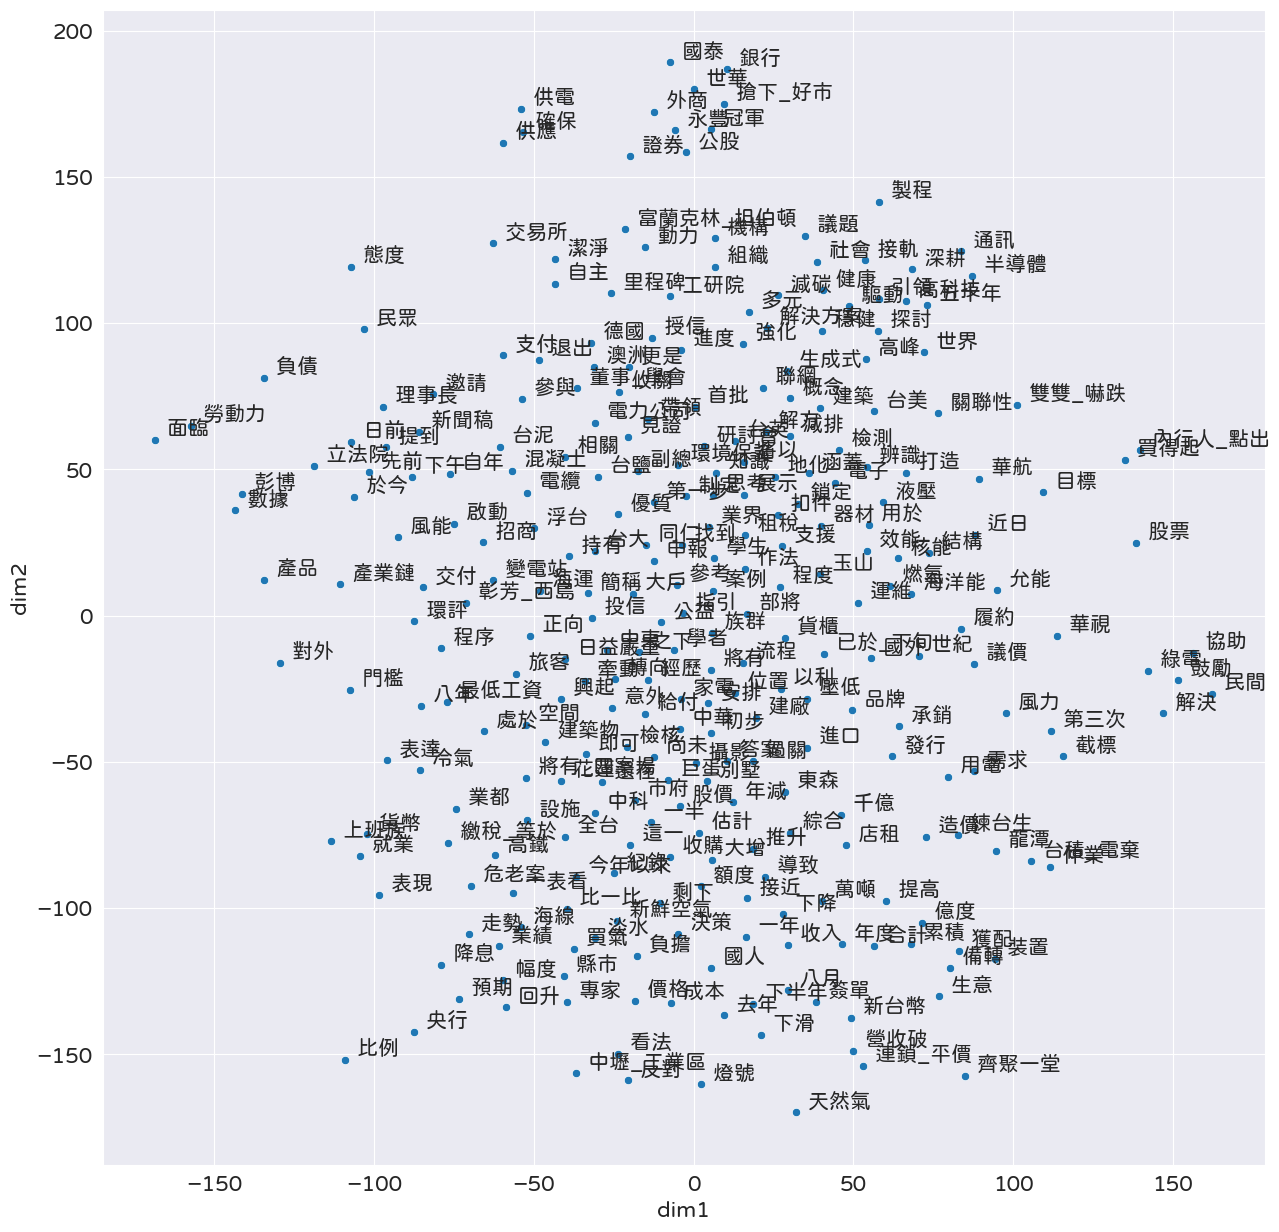

In [60]:
plotScatter(word_df)

### 3-5. 3D散點圖

In [61]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


### 3-6. 將字做分群並視覺化

In [62]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [63]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## 4. 建立bert-ch模型

In [64]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

/var/folders/2q/r2vqr_g50sz68tkjg_dd_1y40000gn/T/ipykernel_24324/852741673.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,日圓一直貶值會怎樣？ 一張表曝光日本企業鮮為人知的營業利益貢獻,最近筆者常被詢問對於一檔即將募集的日本龍頭企業基金的看法這些朋友大多有閒錢約幾十萬又聽業務員...
1,2,碳權交易所營運勢將再加速綠領人才需求 十年成長6.5倍,台灣碳權交易所今日正式營運加速帶動相關人才需求綠領新貴勢將成為就業市場當紅炸子雞根據人力銀行...
2,3,台灣碳權交易所揭牌 蔡總統：整體創造5.9兆元產值,台灣碳權交易所今天正式揭牌總統蔡英文說從年到年淨零碳排整體努力預計帶動兆元以上民間投資創造兆...
3,4,台灣碳權交易所揭牌 蔡總統：持續協助企業面對淨零轉型,蔡總統今日前往高雄出席台灣碳權交易所開幕揭牌典禮時指出碳權交易所的設置能讓台灣跟上國際淨零轉...
4,5,產業力拚碳中和 業者：法規限制為減碳最大挑戰,台灣碳權交易所今天揭牌國內傳統產業碳排大戶靜待相關子法出爐期盼透過碳權買賣協助企業達標碳中和...


In [65]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with MEAN pooling.
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



0

### 4-1. 透過Bert-ch做embedding並尋找相似的文章

In [66]:
corpus_embeddings = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 允能與海能風場挨罰 債權銀行：努力讓案子完成

 資料集中前五相似的文章:
允能與海能風場挨罰 債權銀行：努力讓案子完成 (Score: 1.0000)
允能、海能風場進度落後 挨罰 (Score: 0.9882)
離岸風電3-2期10日截標 台亞不玩了 (Score: 0.9861)
中信銀看好國產化降風電成本 主辦風電聯貸已逾3千億 (Score: 0.9859)
一期離岸風機一直壞 台電：契約有要求廠商負責維運 (Score: 0.9858)






In [35]:
query_num = 31

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 確保「有船可用」 台亞風能與星國船商Cyan簽訂MOU

 資料集中前五相似的文章:
確保「有船可用」 台亞風能與星國船商Cyan簽訂MOU (Score: 1.0000)
貝富新能源與台大簽署MOU 聚焦人才培育及技術研發 (Score: 0.9900)
本土海事工程崛起 東方風能統包台澎金馬四號海纜建置 (Score: 0.9886)
安捷航空攜手歐洲直升機大廠 台灣離岸風電添新戰力 (Score: 0.9880)
太古與天力簽署 MOU 在台灣提供離岸風電解決方案 (Score: 0.9878)






## 5. 透過llama-3-7b做embedding試試效果

In [36]:
from huggingface_hub import notebook_login
notebook_login() # 輸入Hugging Face 帳號的Token

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
parser.add_argument('--device', type=int, default=0)
parser.add_argument('--use_gpu',default=False,action='store_true')

use_gpu = args.use_gpu
device = torch.device("mps" if args.use_gpu else "cpu")

NameError: name 'parser' is not defined

In [38]:
model_llama = SentenceTransformer('meta-llama/Llama-2-7b-hf').to(device)
model_llama.tokenizer.pad_token = model_llama.tokenizer.eos_token

No sentence-transformers model found with name meta-llama/Llama-2-7b-hf. Creating a new one with MEAN pooling.
/opt/anaconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 18.07 GB, other allocations: 736.00 KB, max allowed: 18.13 GB). Tried to allocate 172.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
query_num = 31

# 定義函式以將文章內容轉換為嵌入向量
def get_embedding_llama(text, model):
    return model.encode(text)

# 創建一個空的列表來存儲所有文章的嵌入向量
corpus_embeddings = []

# 將每個文章的內容轉換為嵌入向量並添加到列表中
for content in df_similar['artContent']:
    embedding = get_embedding_llama(content, model_llama)
    corpus_embeddings.append(embedding)

# 將列表轉換為 PyTorch 張量
corpus_embeddings = torch.stack(corpus_embeddings)

# 轉換查詢文章的內容為嵌入向量
query_embedding = get_embedding_llama(df_similar['artContent'][query_num], model_llama)

# 使用余弦相似度計算查詢文章與每個文章的相似度
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

# 找到相似度最高的前五個文章
top_results = torch.topk(cos_scores, k=top_k)

# 印出相似度最高的前五篇文章
print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")